In [ ]:
# --- Install necessary libraries ---
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install ucimlrepo
!pip install xgboost catboost

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- Preprocessing and Metrics ---
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# --- Machine Learning Models ---
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


# --- Data Loading ---
from ucimlrepo import fetch_ucirepo
from pandas_profiling import ProfileReport

# --- Settings ---
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

In [ ]:
# Fetch dataset
try:
    maternal_health_risk = fetch_ucirepo(id=863)
    X_features = maternal_health_risk.data.features
    y_target = maternal_health_risk.data.targets
    df = pd.concat([X_features, y_target], axis=1)
    print("--- Dataset loaded successfully ---")
    print(f"Dataset shape: {df.shape}")
except Exception as e:
    print(f"Failed to load dataset. Error: {e}")
    df = pd.DataFrame() # Create empty dataframe to avoid further errors


--- Dataset loaded successfully ---
Dataset shape: (1014, 7)


In [ ]:
print("Data Info:")
df.info()
print("\n" + "="*40 + "\n")

# --- 3. Check for Missing Values ---
print("--- Missing Values Check ---")
missing_values = df.isnull().sum()
print("Number of missing values per column:")
print(missing_values)
print("\n" + "="*40 + "\n")

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


--- Missing Values Check ---
Number of missing values per column:
Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64




In [ ]:
# --- 4. Check for Duplicated Values ---
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows found: {num_duplicates}")
# Drop duplicates
df = df.drop_duplicates()
print(f"Shape after dropping duplicates: {df.shape}")
print("\n" + "="*40 + "\n")

Number of duplicate rows found: 562
Shape after dropping duplicates: (452, 7)




In [ ]:
# --- 5. Handle Outliers using IQR ---
print("--- Handling Outliers using IQR ---")
print("For this specific problem, the presence of statistical outliers is\na key feature of the data, not a flaw.Proceeding without removing them\nis the correct approach to build a meaningful risk prediction model.")
print("\n" + "="*40 + "\n")

--- Handling Outliers using IQR ---
For this specific problem, the presence of statistical outliers is
a key feature of the data, not a flaw.Proceeding without removing them
is the correct approach to build a meaningful risk prediction model.




--- Visualizing Data Distribution ---


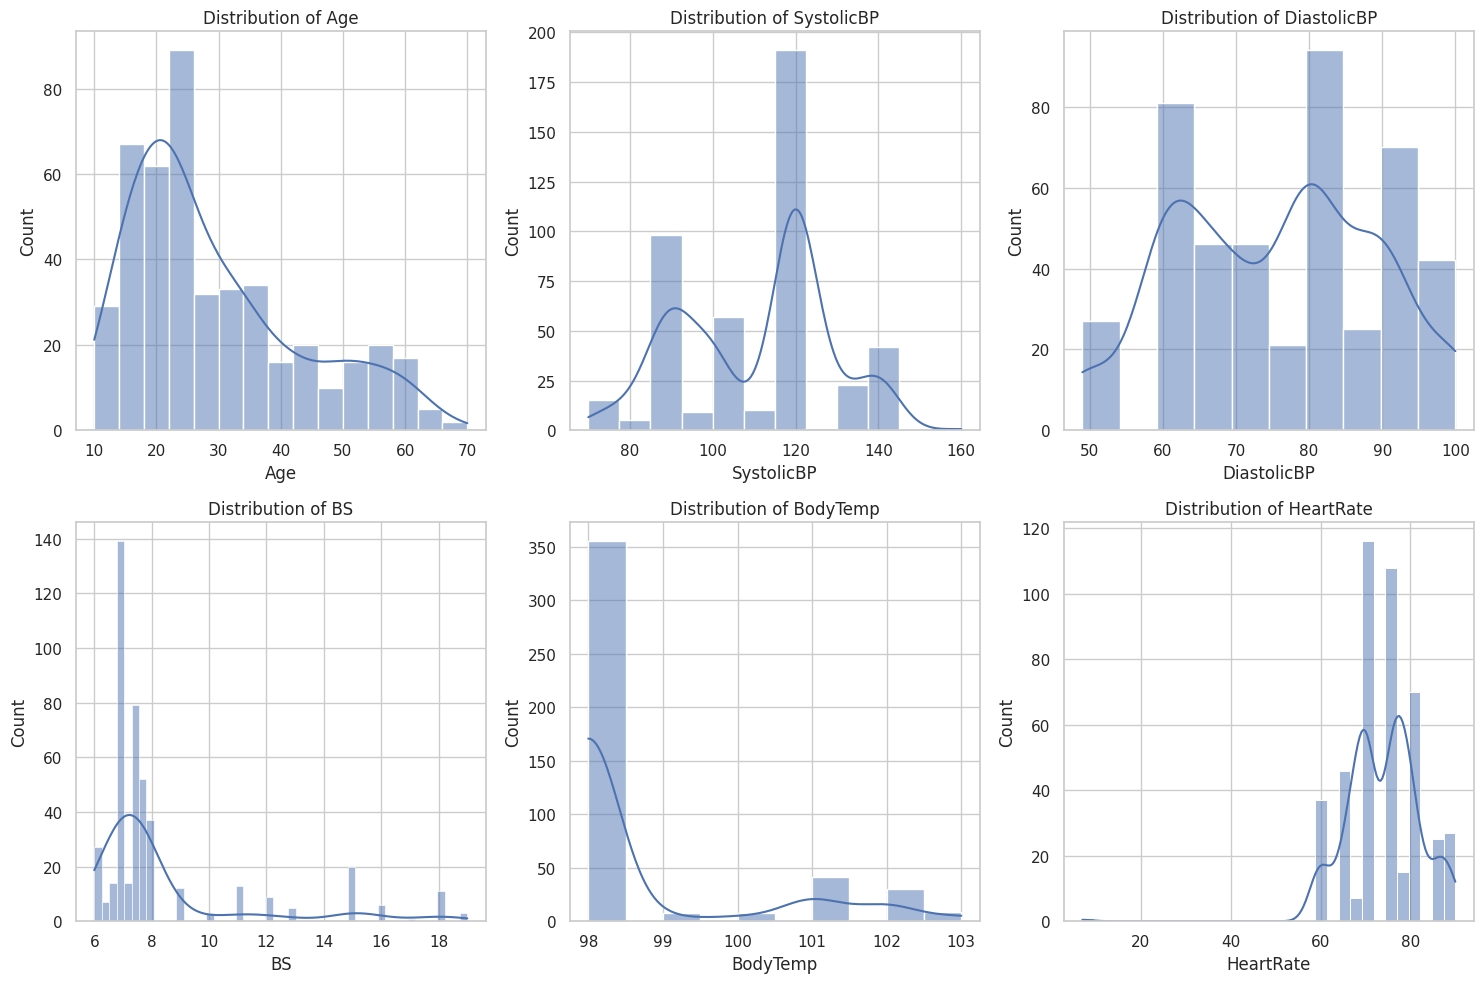

In [ ]:
# --- 6. Visualize Data Distribution ---
print("--- Visualizing Data Distribution ---")

# Plot distribution of numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

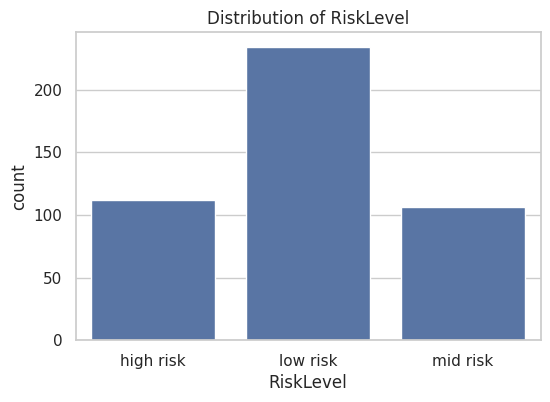

In [ ]:
# Plot distribution of the target variable (categorical)
plt.figure(figsize=(6, 4))
sns.countplot(x='RiskLevel', data=df)
plt.title('Distribution of RiskLevel')
plt.show()

print("\n" + "="*40 + "\n")

In [ ]:
# Manually encode the target variable for modeling
risk_mapping = {'low risk': 0, 'mid risk': 1, 'high risk': 2}
df['RiskLevel_encoded_manual'] = df['RiskLevel'].map(risk_mapping)

print("Manually encoded target variable:")
print(df[['RiskLevel', 'RiskLevel_encoded_manual']].head())
print("\n" + "="*40 + "\n")

Manually encoded target variable:
   RiskLevel  RiskLevel_encoded_manual
0  high risk                         2
1  high risk                         2
2  high risk                         2
3  high risk                         2
4   low risk                         0




In [ ]:
# --- 7. Feature Scaling (Standardization) ---
print("--- Feature Scaling (Standardization) ---")

# Select numerical columns for scaling, EXCLUDING the encoded target variable
numerical_cols_to_scale = df.select_dtypes(include=['int64', 'float64']).columns.drop('RiskLevel_encoded_manual')

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical columns
df[numerical_cols_to_scale] = scaler.fit_transform(df[numerical_cols_to_scale])

print("DataFrame after standardization:")
print(df.head())
print("\n" + "="*40 + "\n")

--- Feature Scaling (Standardization) ---
DataFrame after standardization:
        Age  SystolicBP  DiastolicBP        BS  BodyTemp  HeartRate  \
0 -0.305021    1.089310     0.333484  2.354439 -0.491351   1.479009   
1  0.422139    1.649455     1.061321  1.646744 -0.491351  -0.484676   
2 -0.014157   -1.151273    -0.394352 -0.122492  0.927758   0.742627   
3  0.058559    1.649455     0.697402 -0.476340 -0.491351  -0.484676   
4  0.422139    0.529164    -1.122188 -0.794802 -0.491351   0.251706   

   RiskLevel  RiskLevel_encoded_manual  
0  high risk                         2  
1  high risk                         2  
2  high risk                         2  
3  high risk                         2  
4   low risk                         0  




In [ ]:
# --- Analyze Data Correlation using PCA ---
print("--- Analyzing Data Correlation using PCA ---")

# Select only the scaled numerical columns for correlation and PCA
scaled_numerical_df = df[numerical_cols_to_scale]

--- Analyzing Data Correlation using PCA ---


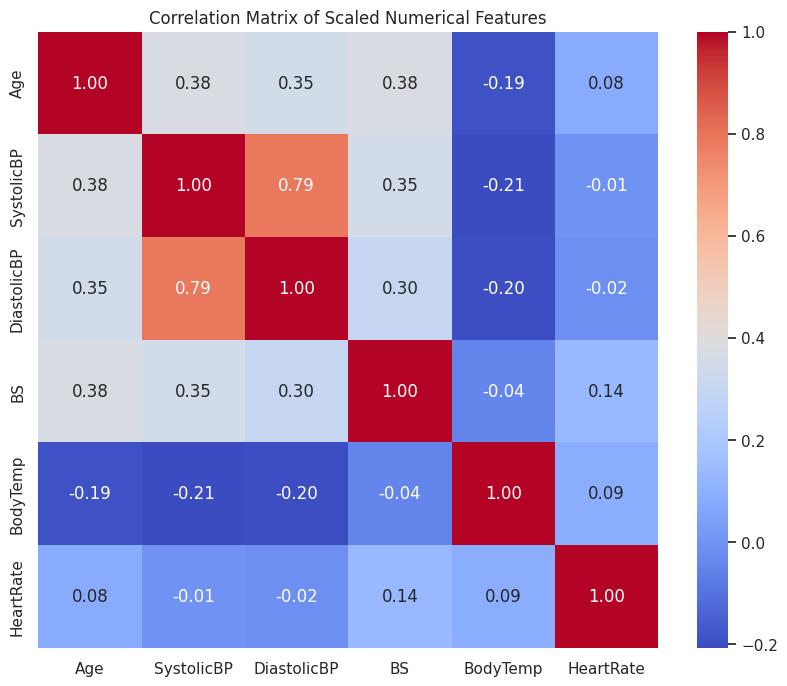

In [ ]:
# Calculate and visualize the correlation matrix
correlation_matrix = scaled_numerical_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Scaled Numerical Features')
plt.show()

In [ ]:
# Perform PCA
pca = PCA()
pca.fit(scaled_numerical_df)


PCA()

In [ ]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("\nExplained variance ratio by each principal component:")
print(explained_variance_ratio)


Explained variance ratio by each principal component:
[0.39708682 0.19148974 0.14703906 0.13060736 0.09908307 0.03469394]


In [ ]:
# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print("\nCumulative explained variance:")
print(cumulative_explained_variance)


Cumulative explained variance:
[0.39708682 0.58857656 0.73561562 0.86622299 0.96530606 1.        ]


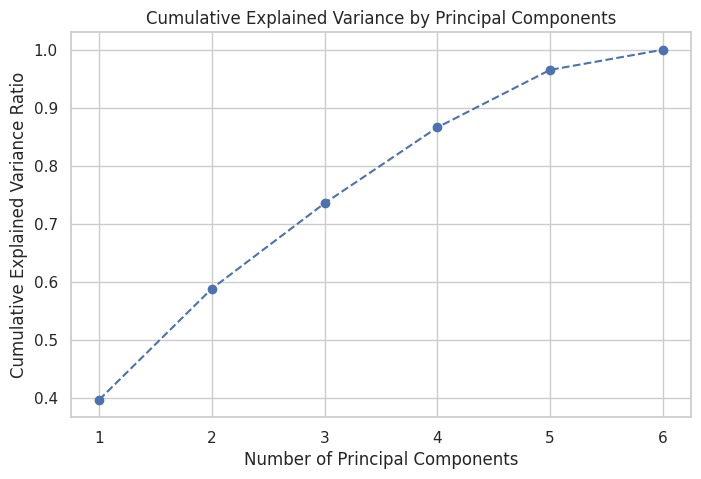

In [ ]:
# Visualize the explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

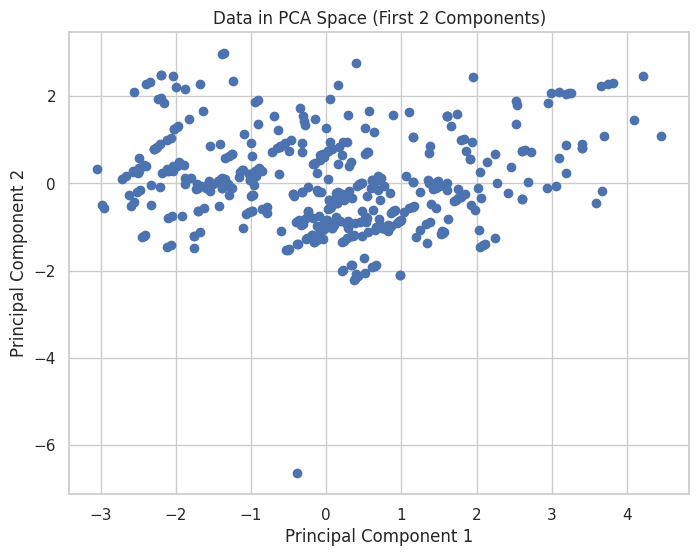

In [ ]:
# Visualize the data in the PCA space (first two components)
pca_2d = PCA(n_components=2)
principal_components = pca_2d.fit_transform(scaled_numerical_df)
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.title('Data in PCA Space (First 2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

print("\n" + "="*40 + "\n")

In [ ]:
# --- Pandas Profiling Report Generation ---
GENERATE_PROFILE_REPORT = False # Set to True to generate the report
if GENERATE_PROFILE_REPORT:
    print("\n\n--- Generating Pandas Profiling Report (on the preprocessed DataFrame 'df') ---")
    if 'df' in locals() and not df.empty:
        profile = ProfileReport(df, title="Pandas Profiling Report (After Preprocessing)", explorative=True)
        profile.to_file("profile_report_after_preprocessing.html")
        print("Profile report saved to 'profile_report_after_preprocessing.html'")
    else:
        print("DataFrame 'df' not available for profiling.")
else:
    print("\nSkipping Pandas Profiling report generation (GENERATE_PROFILE_REPORT is False).")
print("\n" + "="*40 + "\n")



Skipping Pandas Profiling report generation (GENERATE_PROFILE_REPORT is False).




In [ ]:
# --- Helper Function to Plot ROC Curves ---
def plot_multiclass_roc(clf, X_test, y_test, n_classes, class_names, model_name, figsize=(10, 6)):
    """
    Plots the ROC curve for each class in a multi-class classification problem.
    """
    try:
        y_score = clf.predict_proba(X_test)
    except AttributeError:
        print(f"Model {model_name} does not support predict_proba. Skipping ROC curve.")
        return

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver Operating Characteristic (ROC) - {model_name}')
    colors = plt.cm.get_cmap('viridis', n_classes)
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:.2f})')
    ax.legend(loc="lower right")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

In [ ]:
# --- Prepare Data for Modeling ---
# Features are the scaled numerical columns, EXCLUDING the encoded target variable
features = df.select_dtypes(include=np.number).drop('RiskLevel_encoded_manual', axis=1).columns
X = df[features]

# Target is the manually encoded 'RiskLevel', which should NOT be scaled
y = df['RiskLevel_encoded_manual']

# Get class names from the original 'RiskLevel' column for plotting
le = LabelEncoder().fit(df['RiskLevel'])
class_names = le.classes_
n_classes = len(class_names)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("--- Data for Modeling ---")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of classes: {n_classes}")
print(f"Class names: {list(class_names)}")
print("\n" + "="*80 + "\n")

--- Data for Modeling ---
Training set shape: (361, 6)
Test set shape: (91, 6)
Number of classes: 3
Class names: ['high risk', 'low risk', 'mid risk']




In [ ]:
# --- Model and Hyperparameter Grid Definitions ---
results_list = []

param_grids = {
    "RandomForest": {
        "n_estimators": [100, 200],
        "max_depth": [10, None],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "class_weight": ["balanced"]
    },
    "SVC": {
        'C': [1000],
		'gamma': [0.01],
		'kernel': ['rbf']
    },
    "Bagging": {
        "n_estimators": [100, 200],
        "max_samples": [0.7],
        "max_features": [1.0],
    },
    "MLPClassifier": {
        "hidden_layer_sizes": [(50,), (100,)],
        "activation": ["relu"],
        "solver": ["adam"],
        "alpha": [0.0001, 0.001],
        "learning_rate": ["constant"],
        "max_iter": [500]
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'max_depth': [5, 10],
        'learning_rate': [0.01, 0.1],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'gamma': [0, 1],
        'reg_alpha': [0, 0.5],
        'reg_lambda': [1, 1.5],
        'use_label_encoder': [False],
        'eval_metric': ['mlogloss']
    },
    "CatBoost": {
        'iterations': [100, 200],
        'depth': [6, 8],
        'learning_rate': [0.01, 0.1],
        'l2_leaf_reg': [3, 5],
        'bagging_temperature': [1],
        'border_count': [64],
        'verbose': [0]
    },
    "VotingClassifier": {
        'voting': ['hard', 'soft'],
        'svc__C': [1, 100],
        'rf__n_estimators': [100],
        'mlp__hidden_layer_sizes': [(50,)]
    }
}


models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "Bagging": BaggingClassifier(random_state=42),
    "SVC": SVC(probability=True, random_state=42),
    "MLPClassifier": MLPClassifier(random_state=42, max_iter=1000), # Increased max_iter for convergence
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0) # Suppress verbose output for default runs
}



--- Starting Block 1: Train-Test Split Evaluation (80/20) ---

--- Evaluating Model: RandomForest ---
Accuracy: 0.6813
Macro Precision: 0.5840
Macro Recall: 0.5993
Macro F1-Score: 0.5799
ROC AUC (OvR): 0.7962

Classification Report:
              precision    recall  f1-score   support

   high risk       0.73      0.87      0.80        47
    low risk       0.30      0.14      0.19        21
    mid risk       0.72      0.78      0.75        23

    accuracy                           0.68        91
   macro avg       0.58      0.60      0.58        91
weighted avg       0.63      0.68      0.65        91



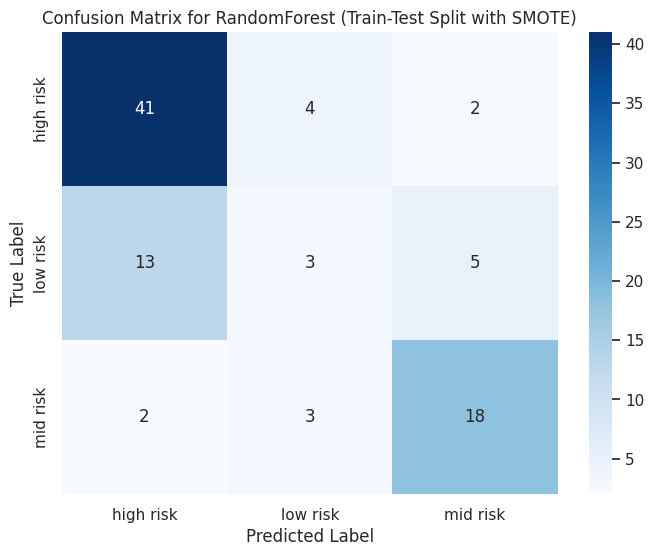

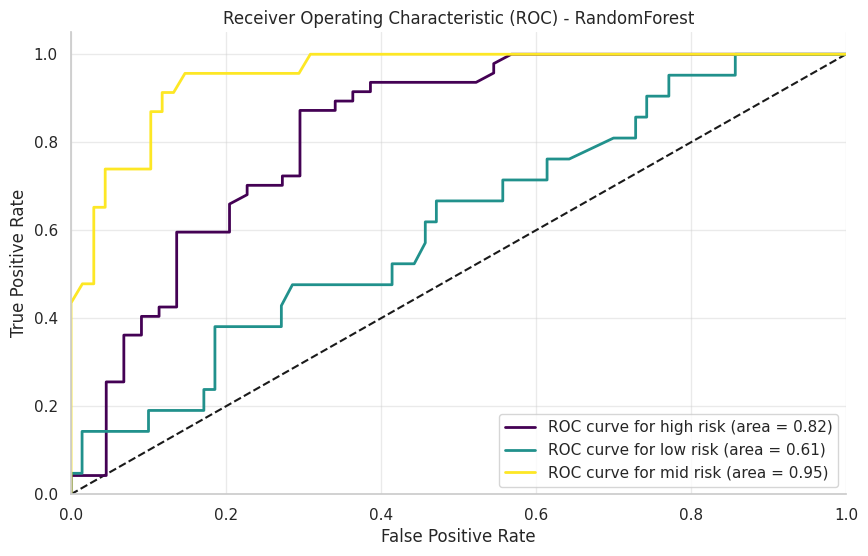


--- Evaluating Model: RandomForest + GS ---
--> Running GridSearchCV for RandomForest...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
--> Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.6703
Macro Precision: 0.6028
Macro Recall: 0.6023
Macro F1-Score: 0.5990
ROC AUC (OvR): 0.7748

Classification Report:
              precision    recall  f1-score   support

   high risk       0.74      0.83      0.78        47
    low risk       0.33      0.24      0.28        21
    mid risk       0.74      0.74      0.74        23

    accuracy                           0.67        91
   macro avg       0.60      0.60      0.60        91
weighted avg       0.64      0.67      0.65        91



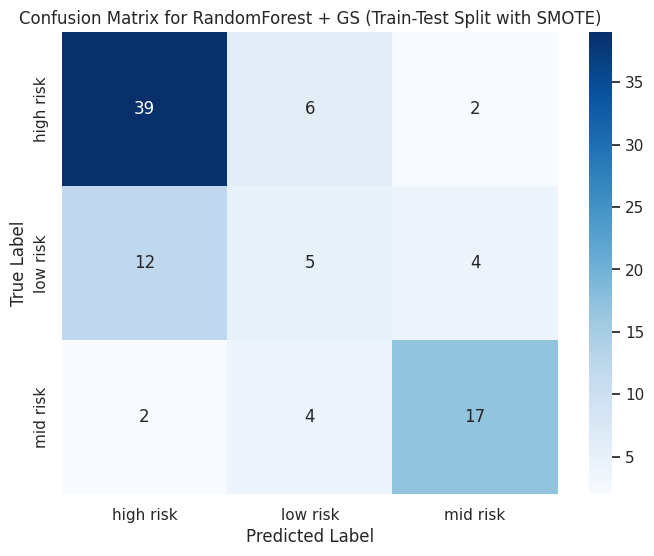

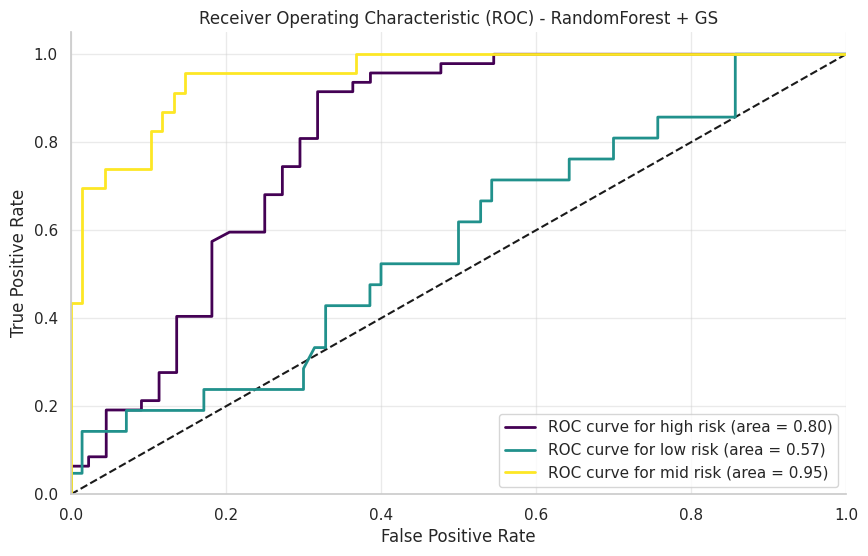


--- Evaluating Model: Bagging ---
Accuracy: 0.6703
Macro Precision: 0.6128
Macro Recall: 0.6185
Macro F1-Score: 0.6148
ROC AUC (OvR): 0.7984

Classification Report:
              precision    recall  f1-score   support

   high risk       0.76      0.79      0.77        47
    low risk       0.33      0.29      0.31        21
    mid risk       0.75      0.78      0.77        23

    accuracy                           0.67        91
   macro avg       0.61      0.62      0.61        91
weighted avg       0.66      0.67      0.66        91



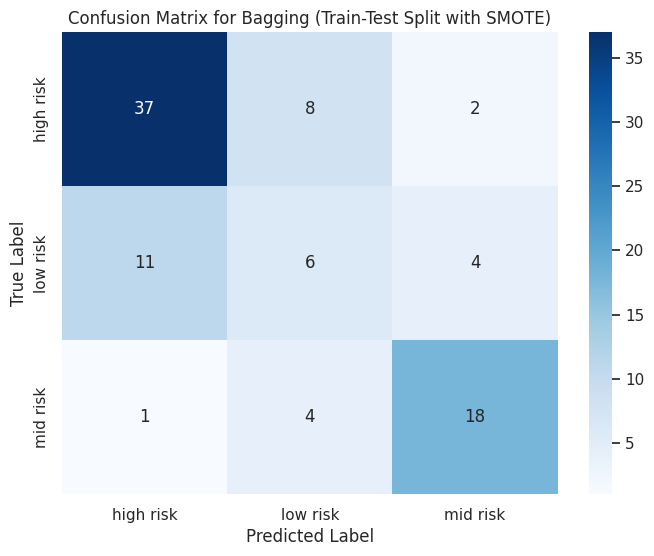

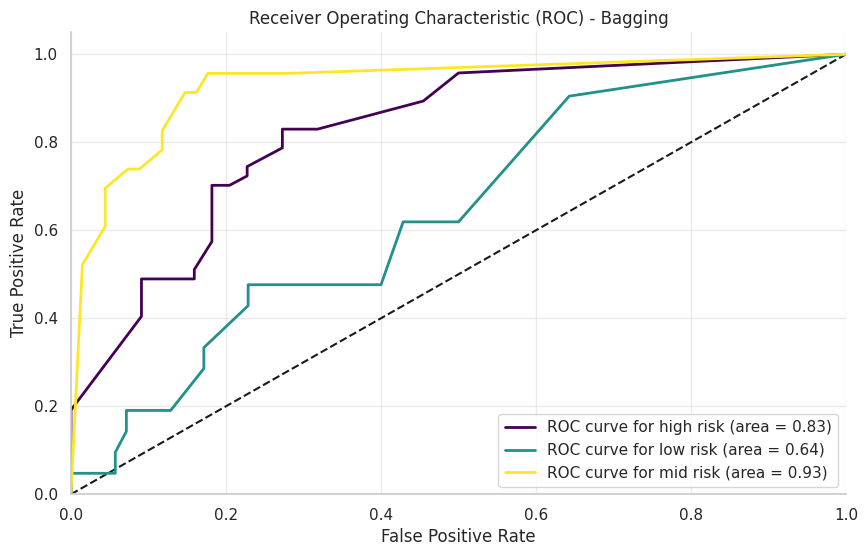


--- Evaluating Model: Bagging + GS ---
--> Running GridSearchCV for Bagging...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
--> Best Parameters: {'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 200}
Accuracy: 0.6703
Macro Precision: 0.5968
Macro Recall: 0.6010
Macro F1-Score: 0.5945
ROC AUC (OvR): 0.7976

Classification Report:
              precision    recall  f1-score   support

   high risk       0.72      0.83      0.77        47
    low risk       0.29      0.19      0.23        21
    mid risk       0.78      0.78      0.78        23

    accuracy                           0.67        91
   macro avg       0.60      0.60      0.59        91
weighted avg       0.64      0.67      0.65        91



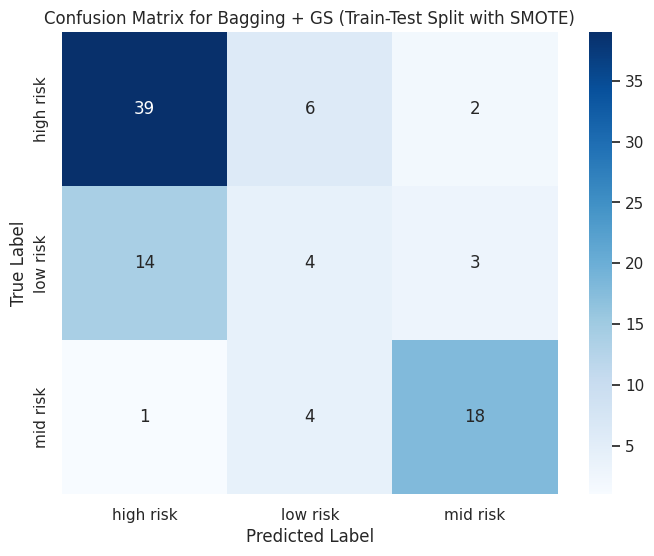

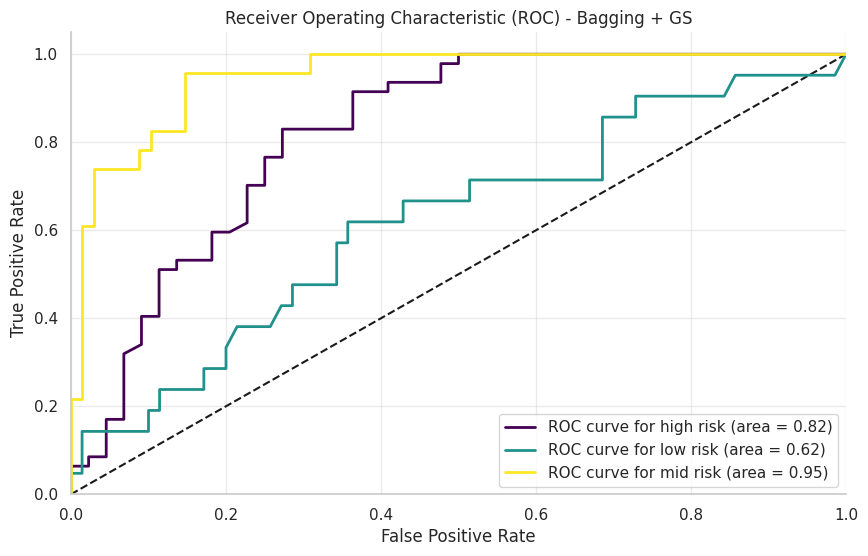


--- Evaluating Model: SVC ---
Accuracy: 0.6593
Macro Precision: 0.5872
Macro Recall: 0.5865
Macro F1-Score: 0.5834
ROC AUC (OvR): 0.7661

Classification Report:
              precision    recall  f1-score   support

   high risk       0.72      0.83      0.77        47
    low risk       0.27      0.19      0.22        21
    mid risk       0.77      0.74      0.76        23

    accuracy                           0.66        91
   macro avg       0.59      0.59      0.58        91
weighted avg       0.63      0.66      0.64        91



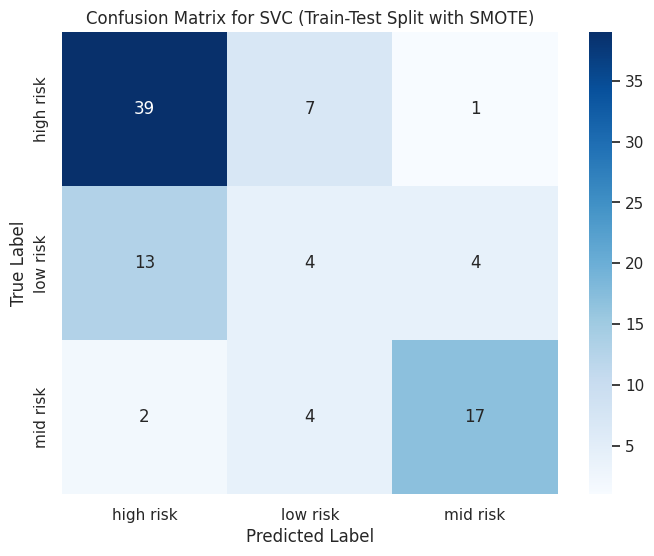

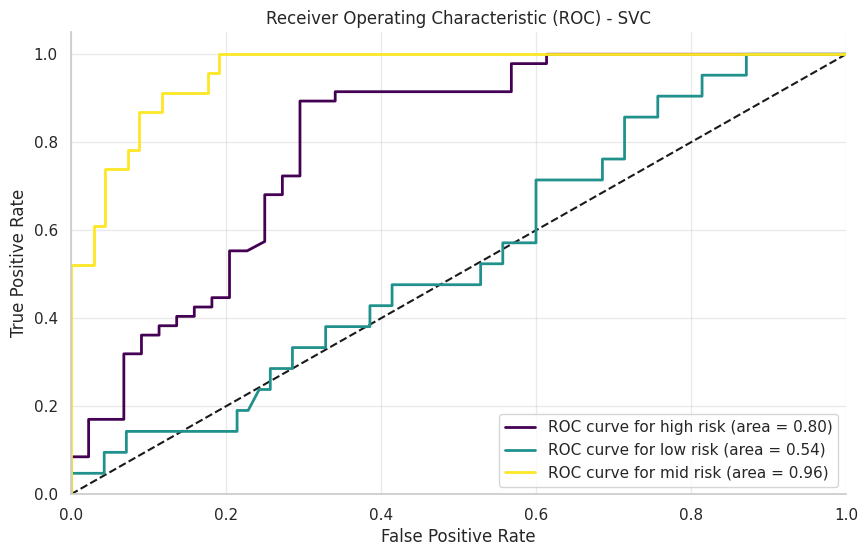


--- Evaluating Model: SVC + GS ---
--> Running GridSearchCV for SVC...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
--> Best Parameters: {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy: 0.6813
Macro Precision: 0.5899
Macro Recall: 0.5919
Macro F1-Score: 0.5810
ROC AUC (OvR): 0.7434

Classification Report:
              precision    recall  f1-score   support

   high risk       0.72      0.89      0.80        47
    low risk       0.27      0.14      0.19        21
    mid risk       0.77      0.74      0.76        23

    accuracy                           0.68        91
   macro avg       0.59      0.59      0.58        91
weighted avg       0.63      0.68      0.65        91



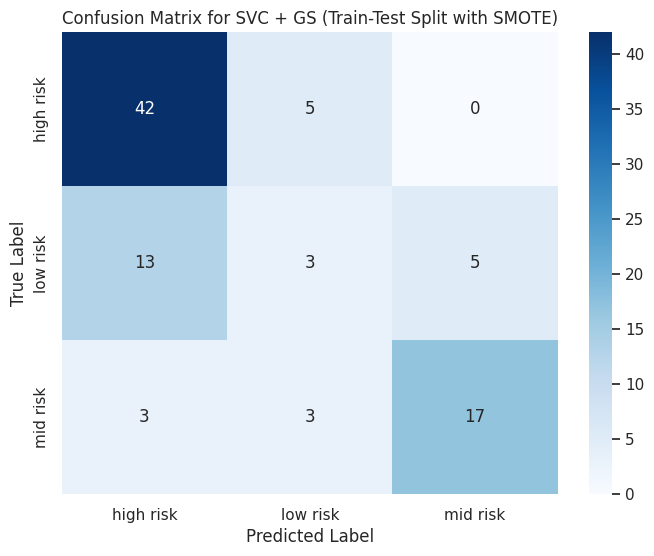

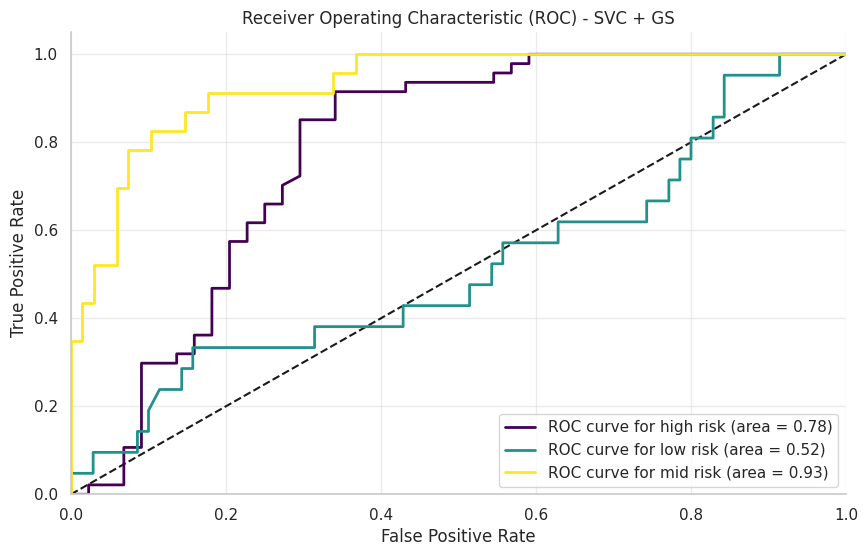


--- Evaluating Model: MLPClassifier ---
Accuracy: 0.6374
Macro Precision: 0.5696
Macro Recall: 0.5811
Macro F1-Score: 0.5738
ROC AUC (OvR): 0.7365

Classification Report:
              precision    recall  f1-score   support

   high risk       0.73      0.77      0.75        47
    low risk       0.29      0.24      0.26        21
    mid risk       0.68      0.74      0.71        23

    accuracy                           0.64        91
   macro avg       0.57      0.58      0.57        91
weighted avg       0.62      0.64      0.63        91



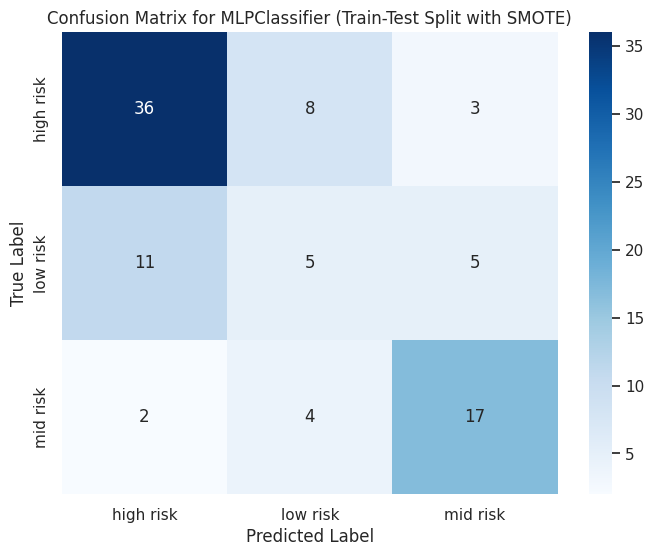

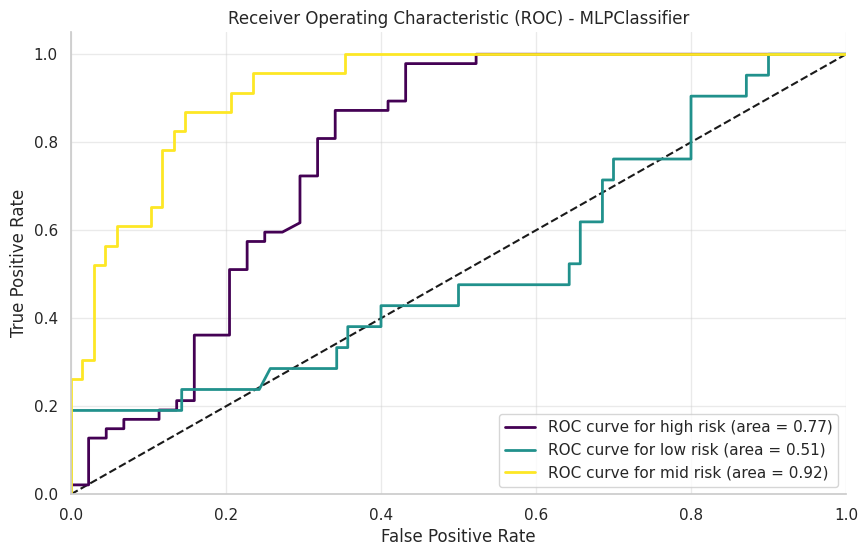


--- Evaluating Model: MLPClassifier + GS ---
--> Running GridSearchCV for MLPClassifier...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
--> Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}
Accuracy: 0.6593
Macro Precision: 0.5905
Macro Recall: 0.6174
Macro F1-Score: 0.5998
ROC AUC (OvR): 0.7444

Classification Report:
              precision    recall  f1-score   support

   high risk       0.74      0.74      0.74        47
    low risk       0.31      0.24      0.27        21
    mid risk       0.71      0.87      0.78        23

    accuracy                           0.66        91
   macro avg       0.59      0.62      0.60        91
weighted avg       0.64      0.66      0.65        91



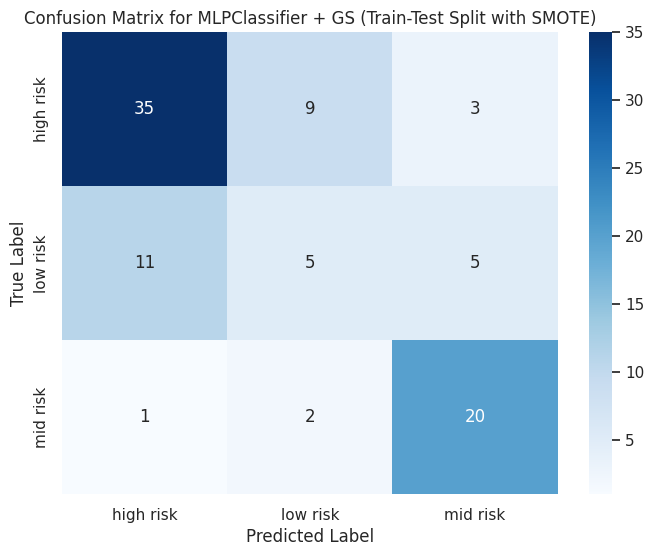

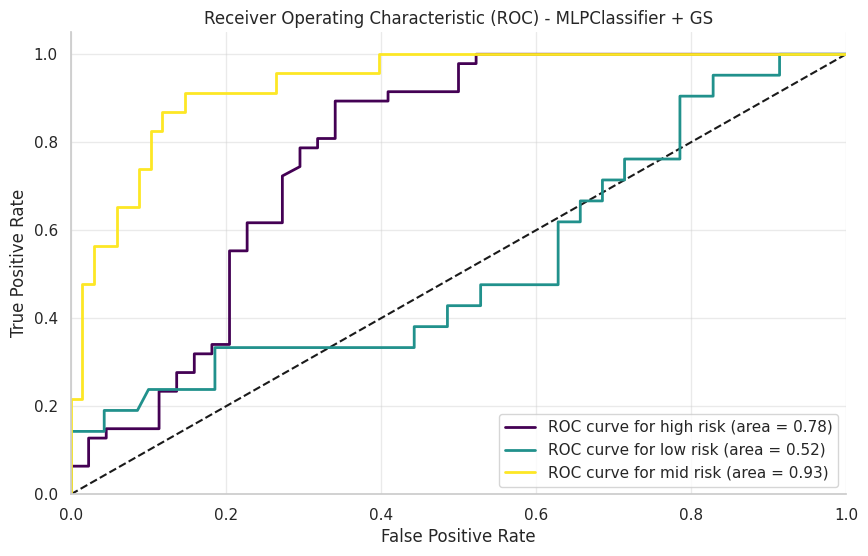


--- Evaluating Model: XGBoost ---
Accuracy: 0.6813
Macro Precision: 0.6214
Macro Recall: 0.6182
Macro F1-Score: 0.6171
ROC AUC (OvR): 0.8070

Classification Report:
              precision    recall  f1-score   support

   high risk       0.75      0.83      0.79        47
    low risk       0.38      0.29      0.32        21
    mid risk       0.74      0.74      0.74        23

    accuracy                           0.68        91
   macro avg       0.62      0.62      0.62        91
weighted avg       0.66      0.68      0.67        91



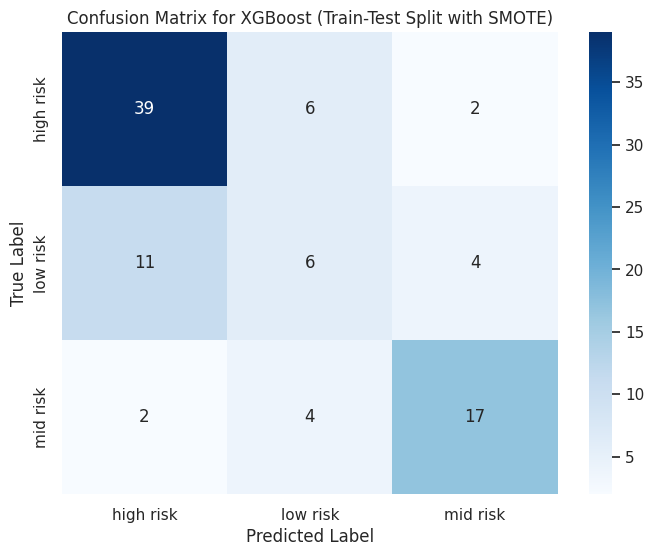

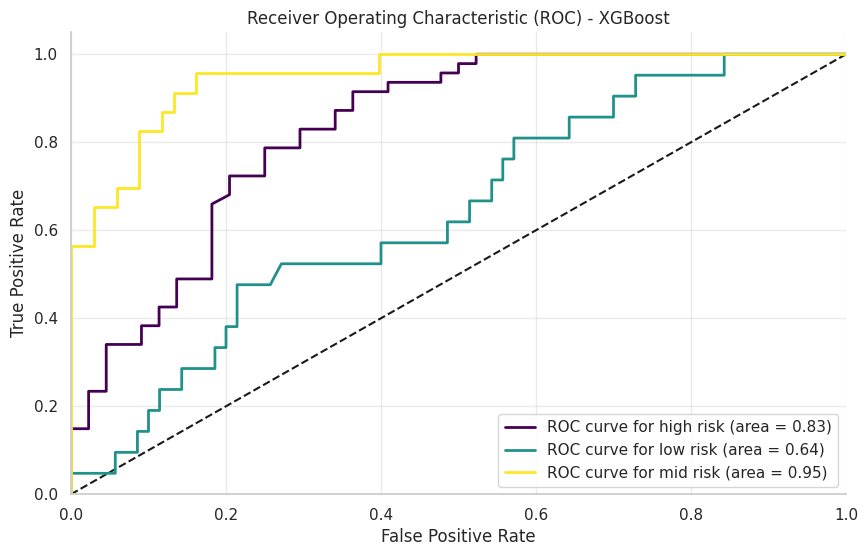


--- Evaluating Model: XGBoost + GS ---
--> Running GridSearchCV for XGBoost...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
--> Best Parameters: {'colsample_bytree': 1.0, 'eval_metric': 'mlogloss', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0, 'use_label_encoder': False}
Accuracy: 0.6813
Macro Precision: 0.6316
Macro Recall: 0.6182
Macro F1-Score: 0.6204
ROC AUC (OvR): 0.7923

Classification Report:
              precision    recall  f1-score   support

   high risk       0.72      0.83      0.77        47
    low risk       0.40      0.29      0.33        21
    mid risk       0.77      0.74      0.76        23

    accuracy                           0.68        91
   macro avg       0.63      0.62      0.62        91
weighted avg       0.66      0.68      0.67        91



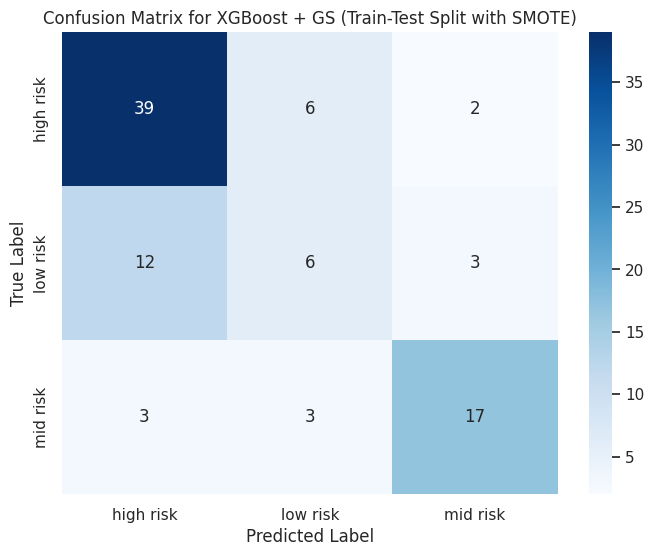

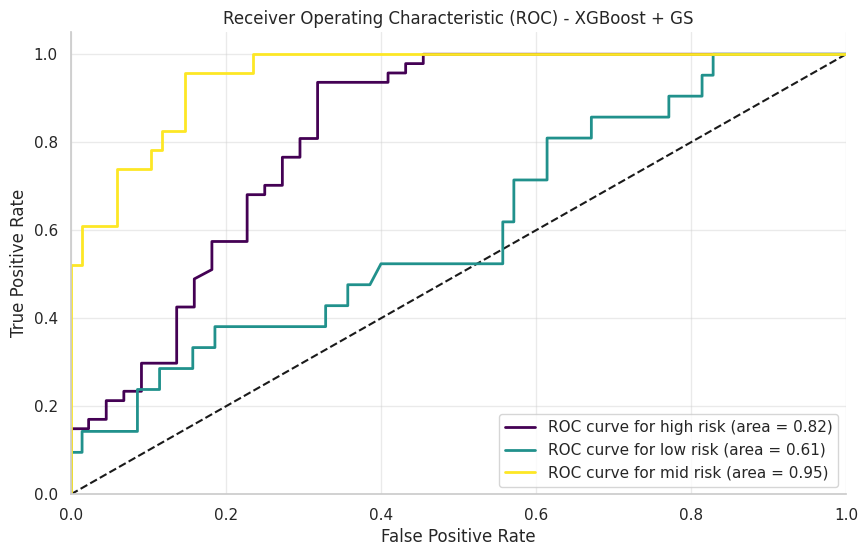


--- Evaluating Model: CatBoost ---
Accuracy: 0.6813
Macro Precision: 0.6150
Macro Recall: 0.6168
Macro F1-Score: 0.6136
ROC AUC (OvR): 0.7795

Classification Report:
              precision    recall  f1-score   support

   high risk       0.75      0.83      0.79        47
    low risk       0.31      0.24      0.27        21
    mid risk       0.78      0.78      0.78        23

    accuracy                           0.68        91
   macro avg       0.62      0.62      0.61        91
weighted avg       0.66      0.68      0.67        91



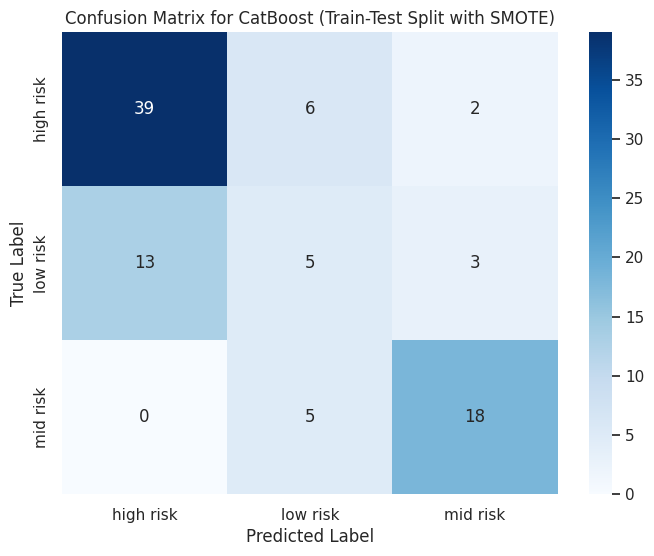

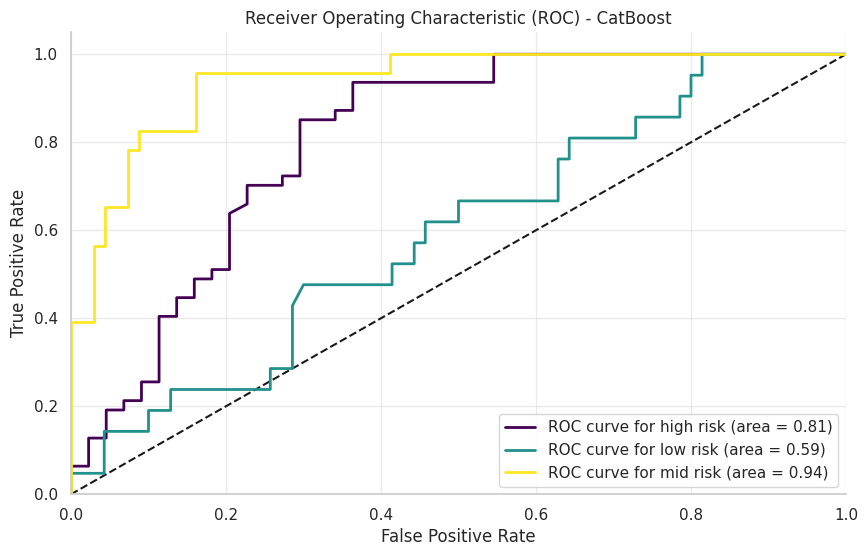


--- Evaluating Model: CatBoost + GS ---
--> Running GridSearchCV for CatBoost...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
--> Best Parameters: {'bagging_temperature': 1, 'border_count': 64, 'depth': 6, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1, 'verbose': 0}
Accuracy: 0.6813
Macro Precision: 0.5971
Macro Recall: 0.6155
Macro F1-Score: 0.6033
ROC AUC (OvR): 0.7813

Classification Report:
              precision    recall  f1-score   support

   high risk       0.76      0.83      0.80        47
    low risk       0.27      0.19      0.22        21
    mid risk       0.76      0.83      0.79        23

    accuracy                           0.68        91
   macro avg       0.60      0.62      0.60        91
weighted avg       0.65      0.68      0.66        91



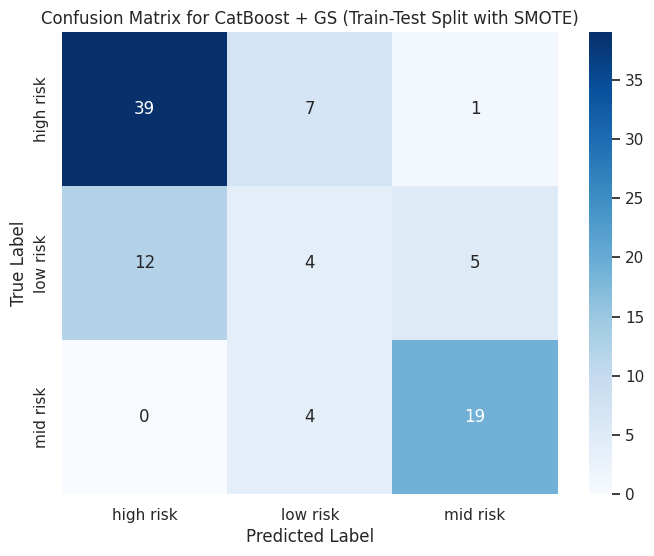

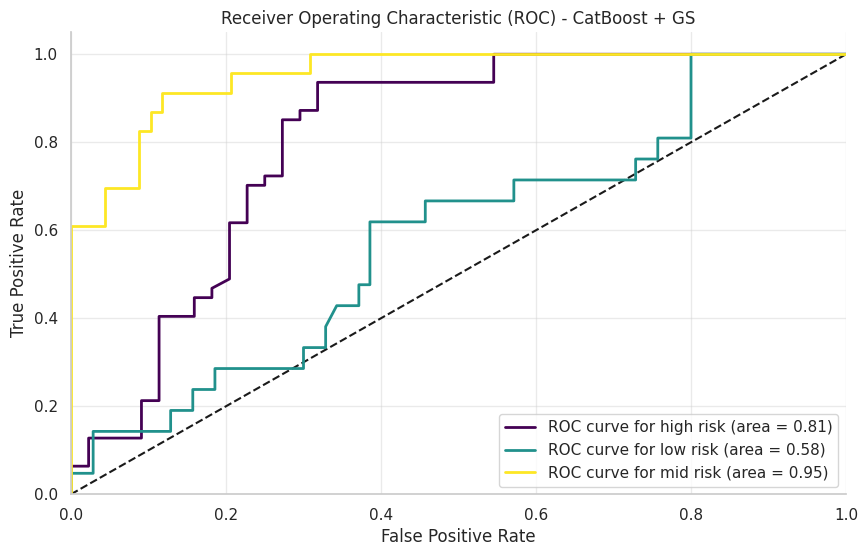


--- Finished Block 1: Train-Test Split Evaluation (80/20) ---



In [ ]:
# --- Block 1: Train-Test Split Evaluation (80/20) ---
print("--- Starting Block 1: Train-Test Split Evaluation (80/20) ---")

# Initialize SMOTE
smote = SMOTE(random_state=42)

for name, model in models.items():
    for use_grid in [False, True]:
        # Skip GridSearch if model has no param_grid
        if use_grid and name not in param_grids:
            continue

        tag = " + GS" if use_grid else ""
        model_name_tagged = f"{name}{tag}"
        print(f"\n--- Evaluating Model: {model_name_tagged} ---")

        # Apply SMOTE to the training data
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        if use_grid:
            print(f"--> Running GridSearchCV for {name}...")
            gs = GridSearchCV(model, param_grids[name], cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
            gs.fit(X_train_smote, y_train_smote)
            best_model = gs.best_estimator_
            print(f"--> Best Parameters: {gs.best_params_}")
        else:
            # For CatBoost, need to handle categorical features if any (none in this case)
            if name == "CatBoost":
                model.fit(X_train_smote, y_train_smote, verbose=0)
            else:
                model.fit(X_train_smote, y_train_smote)
            best_model = model

        # Make predictions
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Macro Precision: {precision:.4f}")
        print(f"Macro Recall: {recall:.4f}")
        print(f"Macro F1-Score: {f1:.4f}")
        print(f"ROC AUC (OvR): {roc_auc:.4f}")

        # Store results
        results_list.append({
            "Model": model_name_tagged,
            "Evaluation Method": "Train-Test Split (with SMOTE)",
            "Accuracy": accuracy,
            "Precision (Macro)": precision,
            "Recall (Macro)": recall,
            "F1-Score (Macro)": f1,
            "ROC AUC (OvR)": roc_auc,
            "Best Model": best_model # Store the trained model
        })

        # Classification Report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix for {model_name_tagged} (Train-Test Split with SMOTE)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        # ROC Curve
        plot_multiclass_roc(best_model, X_test, y_test, n_classes=n_classes, class_names=class_names, model_name=model_name_tagged)

print("\n" + "="*80)
print("--- Finished Block 1: Train-Test Split Evaluation (80/20) ---")
print("="*80 + "\n")

--- Starting Block 2: 10-Fold CV with SMOTE on train fold only ---

--- Evaluating Model: RandomForest (10-Fold CV) ---
Average Accuracy: 0.6259 (± 0.0523)
Average Macro Precision: 0.5732 (± 0.0384)
Average Macro Recall: 0.5791 (± 0.0548)
Average Macro F1-Score: 0.5718 (± 0.0472)
Average ROC AUC (OvR): 0.7511 (± 0.0438)


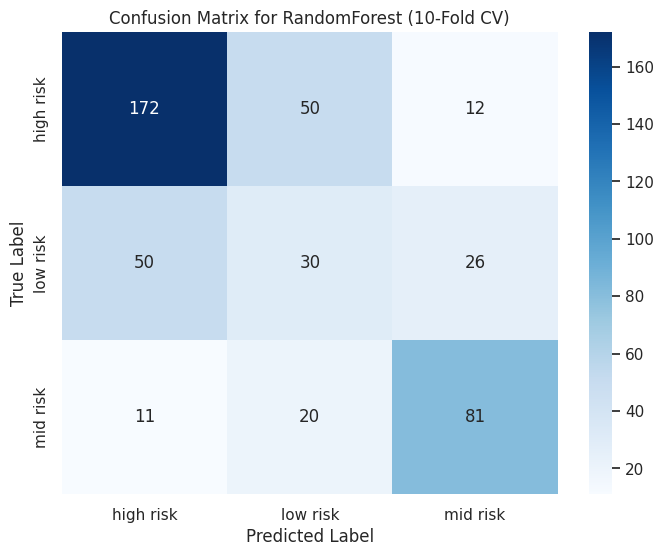


--- Evaluating Model: RandomForest + GS (10-Fold CV) ---
Average Accuracy: 0.6414 (± 0.0587)
Average Macro Precision: 0.5872 (± 0.0384)
Average Macro Recall: 0.5878 (± 0.0534)
Average Macro F1-Score: 0.5808 (± 0.0437)
Average ROC AUC (OvR): 0.7655 (± 0.0485)


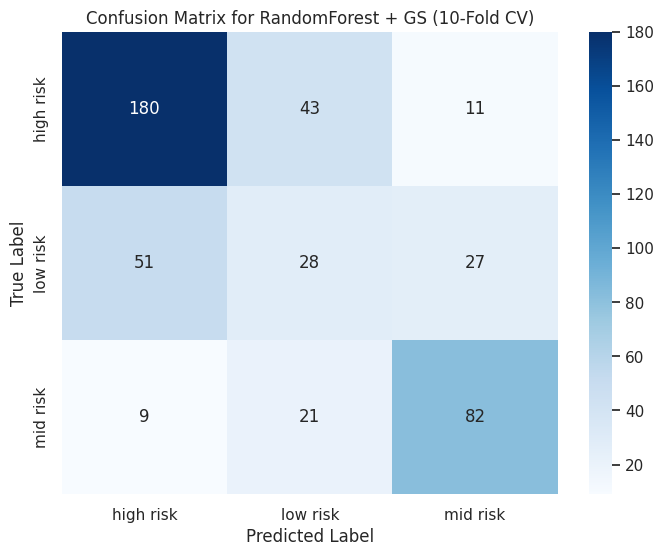


--- Evaluating Model: Bagging (10-Fold CV) ---
Average Accuracy: 0.6240 (± 0.0519)
Average Macro Precision: 0.5750 (± 0.0410)
Average Macro Recall: 0.5735 (± 0.0529)
Average Macro F1-Score: 0.5707 (± 0.0467)
Average ROC AUC (OvR): 0.7381 (± 0.0573)


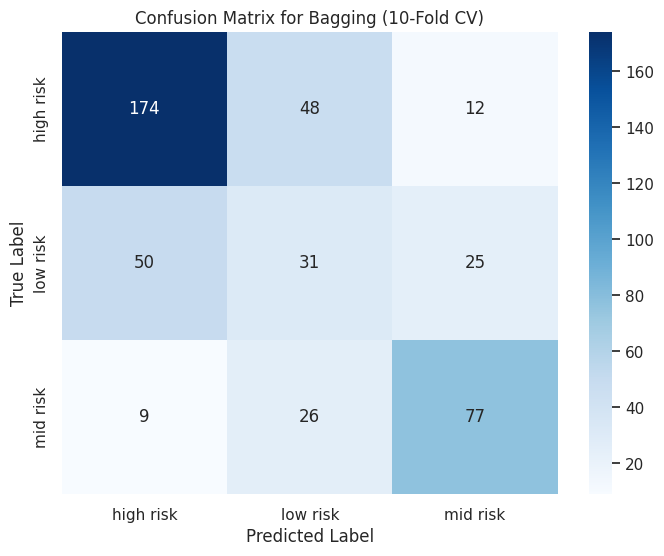


--- Evaluating Model: Bagging + GS (10-Fold CV) ---
Average Accuracy: 0.6348 (± 0.0487)
Average Macro Precision: 0.5871 (± 0.0354)
Average Macro Recall: 0.5869 (± 0.0519)
Average Macro F1-Score: 0.5818 (± 0.0456)
Average ROC AUC (OvR): 0.7647 (± 0.0410)


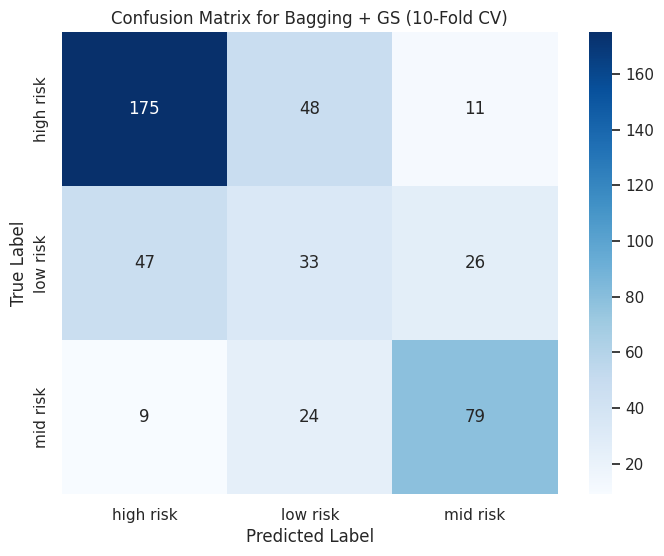


--- Evaluating Model: SVC (10-Fold CV) ---
Average Accuracy: 0.6659 (± 0.0678)
Average Macro Precision: 0.6260 (± 0.0599)
Average Macro Recall: 0.6126 (± 0.0643)
Average Macro F1-Score: 0.6083 (± 0.0561)
Average ROC AUC (OvR): 0.7654 (± 0.0463)


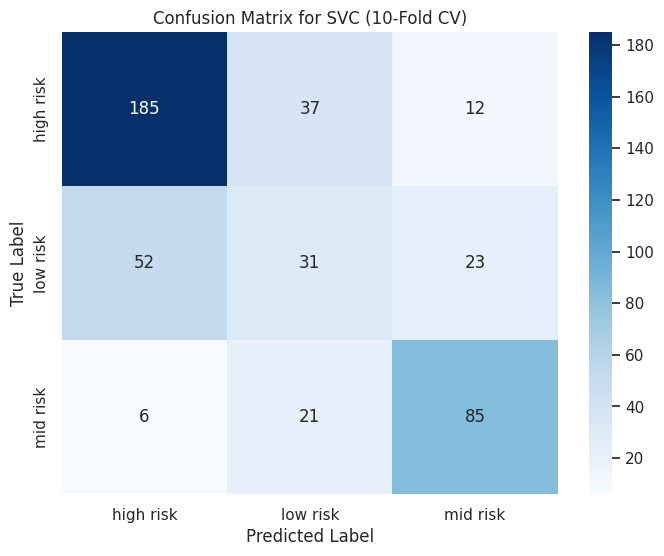


--- Evaluating Model: SVC + GS (10-Fold CV) ---
Average Accuracy: 0.6504 (± 0.0563)
Average Macro Precision: 0.6077 (± 0.0450)
Average Macro Recall: 0.6009 (± 0.0524)
Average Macro F1-Score: 0.5956 (± 0.0457)
Average ROC AUC (OvR): 0.7650 (± 0.0443)


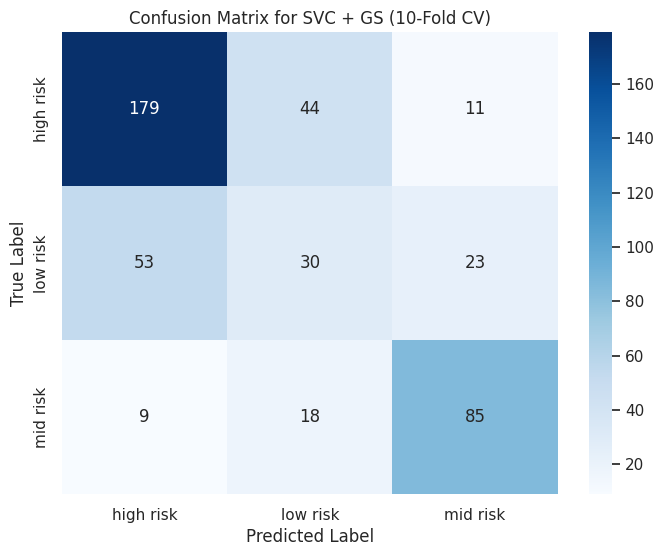


--- Evaluating Model: MLPClassifier (10-Fold CV) ---
Average Accuracy: 0.6282 (± 0.0774)
Average Macro Precision: 0.5988 (± 0.0604)
Average Macro Recall: 0.5902 (± 0.0758)
Average Macro F1-Score: 0.5869 (± 0.0658)
Average ROC AUC (OvR): 0.7540 (± 0.0442)


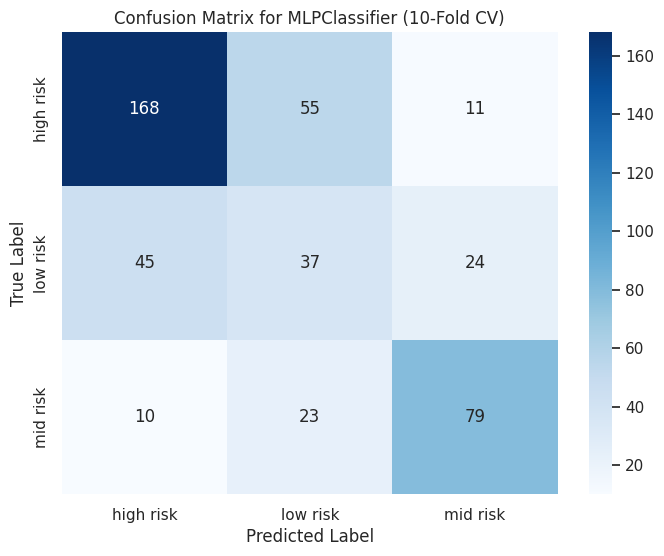


--- Evaluating Model: MLPClassifier + GS (10-Fold CV) ---
Average Accuracy: 0.6240 (± 0.0425)
Average Macro Precision: 0.5909 (± 0.0366)
Average Macro Recall: 0.5852 (± 0.0488)
Average Macro F1-Score: 0.5822 (± 0.0391)
Average ROC AUC (OvR): 0.7659 (± 0.0414)


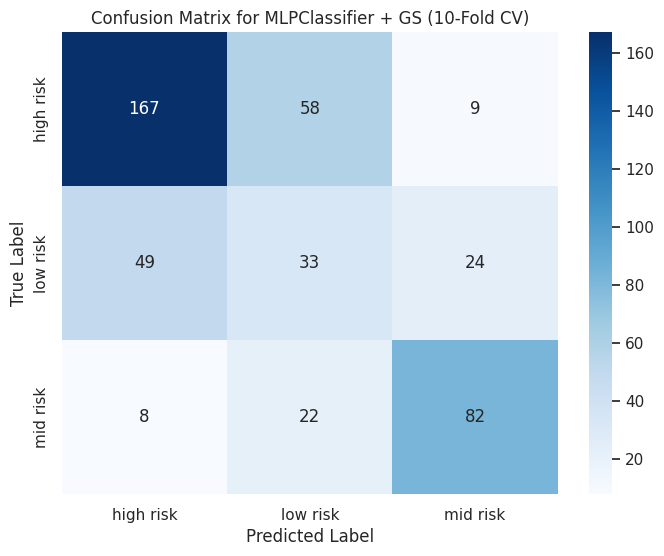


--- Evaluating Model: XGBoost (10-Fold CV) ---
Average Accuracy: 0.6307 (± 0.0489)
Average Macro Precision: 0.5839 (± 0.0499)
Average Macro Recall: 0.5845 (± 0.0545)
Average Macro F1-Score: 0.5793 (± 0.0510)
Average ROC AUC (OvR): 0.7633 (± 0.0449)


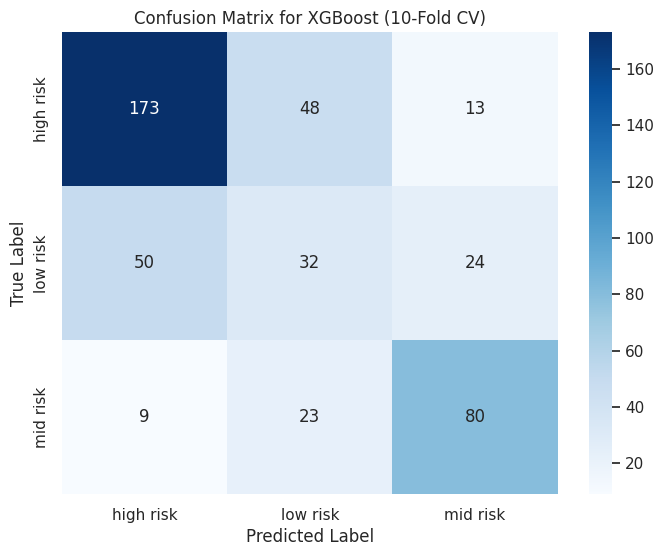


--- Evaluating Model: XGBoost + GS (10-Fold CV) ---
Average Accuracy: 0.6373 (± 0.0497)
Average Macro Precision: 0.5832 (± 0.0535)
Average Macro Recall: 0.5856 (± 0.0527)
Average Macro F1-Score: 0.5815 (± 0.0536)
Average ROC AUC (OvR): 0.7808 (± 0.0471)


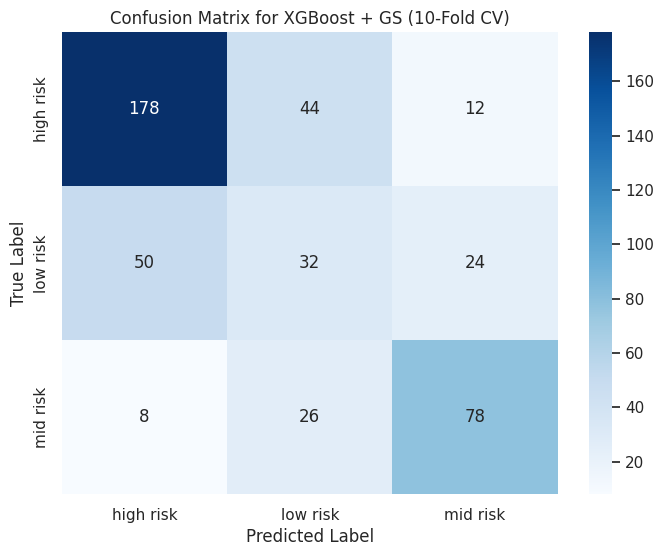


--- Evaluating Model: CatBoost (10-Fold CV) ---
Average Accuracy: 0.6083 (± 0.0465)
Average Macro Precision: 0.5647 (± 0.0404)
Average Macro Recall: 0.5615 (± 0.0461)
Average Macro F1-Score: 0.5603 (± 0.0428)
Average ROC AUC (OvR): 0.7586 (± 0.0485)


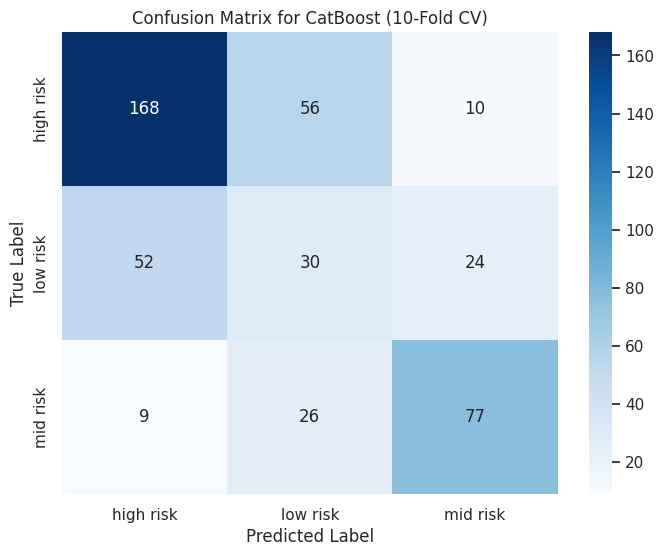


--- Evaluating Model: CatBoost + GS (10-Fold CV) ---
Average Accuracy: 0.6348 (± 0.0719)
Average Macro Precision: 0.5964 (± 0.0433)
Average Macro Recall: 0.5875 (± 0.0588)
Average Macro F1-Score: 0.5869 (± 0.0522)
Average ROC AUC (OvR): 0.7639 (± 0.0455)


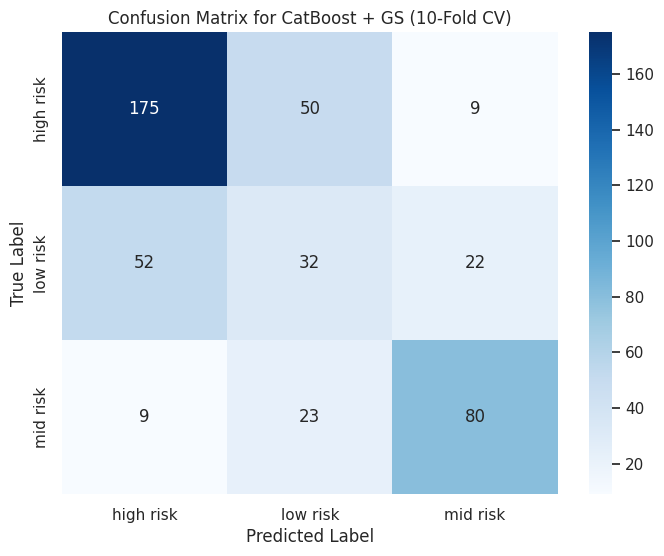


--- Finished Block 2: 10-Fold Cross-Validation Evaluation ---



In [ ]:

# --- Block 2: 10-Fold CV with SMOTE on train fold only ---
print("--- Starting Block 2: 10-Fold CV with SMOTE on train fold only ---")

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    for use_grid in [False, True]:
        if use_grid and name not in param_grids:
            continue

        tag = " + GS" if use_grid else ""
        model_name_tagged = f"{name}{tag}"
        print(f"\n--- Evaluating Model: {model_name_tagged} (10-Fold CV) ---")

        accuracies, precisions, recalls, f1s, aucs = [], [], [], [], []
        all_y_true, all_y_pred, all_y_proba = [], [], []

        for fold, (train_index, test_index) in enumerate(cv.split(X, y)):
            # print(f"  ... Fold {fold+1}/10") # Optional: uncomment to see fold progress
            X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
            y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

            smote_cv = SMOTE(random_state=42)
            X_train_res, y_train_res = smote_cv.fit_resample(X_train_fold, y_train_fold)

            if use_grid:
                gs = GridSearchCV(model, param_grids[name], cv=5, scoring='f1_macro', n_jobs=-1, verbose=0)
                gs.fit(X_train_res, y_train_res)
                best_model_fold = gs.best_estimator_
            else:
                if name == "CatBoost":
                    model.fit(X_train_res, y_train_res, verbose=0)
                else:
                    model.fit(X_train_res, y_train_res)
                best_model_fold = model

            y_pred_fold = best_model_fold.predict(X_test_fold)
            y_proba_fold = best_model_fold.predict_proba(X_test_fold)

            accuracies.append(accuracy_score(y_test_fold, y_pred_fold))
            prec, rec, f1, _ = precision_recall_fscore_support(y_test_fold, y_pred_fold, average='macro', zero_division=0)
            precisions.append(prec)
            recalls.append(rec)
            f1s.append(f1)
            aucs.append(roc_auc_score(y_test_fold, y_proba_fold, multi_class='ovr'))

            all_y_true.extend(y_test_fold)
            all_y_pred.extend(y_pred_fold)
            all_y_proba.extend(y_proba_fold)

        print(f"Average Accuracy: {np.mean(accuracies):.4f} (± {np.std(accuracies):.4f})")
        print(f"Average Macro Precision: {np.mean(precisions):.4f} (± {np.std(precisions):.4f})")
        print(f"Average Macro Recall: {np.mean(recalls):.4f} (± {np.std(recalls):.4f})")
        print(f"Average Macro F1-Score: {np.mean(f1s):.4f} (± {np.std(f1s):.4f})")
        print(f"Average ROC AUC (OvR): {np.mean(aucs):.4f} (± {np.std(aucs):.4f})")

        results_list.append({
            "Model": model_name_tagged,
            "Evaluation Method": "10-Fold CV (SMOTE on Train Only)",
            "Accuracy": np.mean(accuracies),
            "Precision (Macro)": np.mean(precisions),
            "Recall (Macro)": np.mean(recalls),
            "F1-Score (Macro)": np.mean(f1s),
            "ROC AUC (OvR)": np.mean(aucs),
            "Best Model": None # Not applicable for CV average
        })

        # Confusion Matrix for all folds combined
        cm_cv = confusion_matrix(all_y_true, all_y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_cv, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix for {model_name_tagged} (10-Fold CV)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

print("\n" + "="*80)
print("--- Finished Block 2: 10-Fold Cross-Validation Evaluation ---")
print("="*80 + "\n")

In [ ]:
# --- Final Block: Comprehensive Comparison Report ---
print("--- Comprehensive Comparison Report ---")

# Create a DataFrame from the results list, dropping the model objects
final_results_df = pd.DataFrame(results_list).drop(columns=['Best Model'])

# Pivot the table for better comparison
pivot_df = final_results_df.pivot(index='Model', columns='Evaluation Method')

# Style the DataFrame for better readability
# We will highlight the F1-Score as a key metric
styled_pivot = pivot_df.style.background_gradient(
    subset=[('F1-Score (Macro)', 'Train-Test Split (with SMOTE)'),
            ('F1-Score (Macro)', '10-Fold CV (SMOTE on Train Only)')],
    cmap='viridis'
).format("{:.4f}").set_caption("Model Performance Comparison (F1-Score Highlighted)")

print("Displaying summary of model performance metrics:")
display(styled_pivot)

--- Comprehensive Comparison Report ---
Displaying summary of model performance metrics:
